Autoenconder Usando Convoluções

In [6]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.load_mnist import load_mnist

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from utils.load_mnist import load_mnist

Definindo o dispositivo(GPU OU CPU)

In [8]:
print(torch.cuda.is_available())  # Deve retornar True
print(torch.cuda.get_device_name(0))  # Nome da GPU

True
NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Definindo o Modelo

In [10]:
class ConvAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

Treinamento

In [11]:
def train(model, train_loader, epochs=50, lr=1e-3):
    model.to(device)  # Move o modelo para a GPU
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        for batch in train_loader:
            x, _ = batch
            x = x.to(device)  # Move os dados para a GPU
            reconstructed = model(x)
            loss = criterion(reconstructed, x)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Carregando o Dataset MNIST

In [12]:
train_loader = load_mnist()

Instaciando e treinando o modelo

In [13]:
model = ConvAE(input_channels=1, latent_dim=32)
train(model, train_loader)

Epoch [1/50], Loss: 0.0094
Epoch [2/50], Loss: 0.0084
Epoch [3/50], Loss: 0.0071
Epoch [4/50], Loss: 0.0054
Epoch [5/50], Loss: 0.0057
Epoch [6/50], Loss: 0.0059
Epoch [7/50], Loss: 0.0064
Epoch [8/50], Loss: 0.0058
Epoch [9/50], Loss: 0.0053
Epoch [10/50], Loss: 0.0043
Epoch [11/50], Loss: 0.0046
Epoch [12/50], Loss: 0.0048
Epoch [13/50], Loss: 0.0040
Epoch [14/50], Loss: 0.0055
Epoch [15/50], Loss: 0.0049
Epoch [16/50], Loss: 0.0050
Epoch [17/50], Loss: 0.0046
Epoch [18/50], Loss: 0.0043
Epoch [19/50], Loss: 0.0050
Epoch [20/50], Loss: 0.0044
Epoch [21/50], Loss: 0.0054
Epoch [22/50], Loss: 0.0039
Epoch [23/50], Loss: 0.0035
Epoch [24/50], Loss: 0.0037
Epoch [25/50], Loss: 0.0033
Epoch [26/50], Loss: 0.0053
Epoch [27/50], Loss: 0.0046
Epoch [28/50], Loss: 0.0045
Epoch [29/50], Loss: 0.0037
Epoch [30/50], Loss: 0.0043
Epoch [31/50], Loss: 0.0048
Epoch [32/50], Loss: 0.0042
Epoch [33/50], Loss: 0.0045
Epoch [34/50], Loss: 0.0041
Epoch [35/50], Loss: 0.0049
Epoch [36/50], Loss: 0.0038
E

Exportando o Modelo

In [14]:
torch.save(model.state_dict(), 'tests/conv_ae.pth')
print("Modelo Conv AE salvo como 'tests/conv_ae.pth'")

Modelo Conv AE salvo como 'tests/conv_ae.pth'


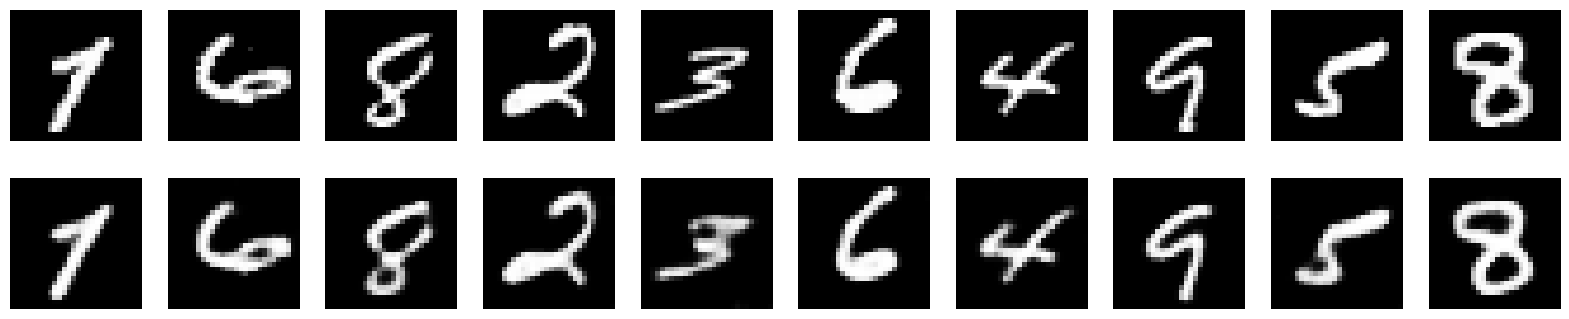

In [15]:
# Visualizar reconstruções
def visualize_reconstructions(model, dataloader):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x = x.to(device)
        reconstructed = model(x).cpu()
        
        # Plotar imagens originais e reconstruídas
        fig, axes = plt.subplots(2, 10, figsize=(20, 4))
        for i in range(10):
            axes[0, i].imshow(x[i].squeeze().cpu(), cmap='gray')
            axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].axis('off')
        plt.show()

visualize_reconstructions(model, train_loader)